In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import calendar
from pandas.tseries import offsets
from datetime import date
import matplotlib.ticker as tkr
# import holidays
from scipy.stats import mstats
import math

%matplotlib inline  

blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
sns.set_palette(sns.color_palette("Paired", 10))
sns.set_style("white")
sns.set_context("notebook", font_scale=3)
season_dict = {"Winter":1, "Spring":2, "Summer":3, "Autumn":4}
# uk_hol= holidays.UK() #load UK holiday

In [94]:
import os
print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "OneDrive - Cardiff University":
        break    
print(computer_path)

/Users/macintosh/Documents/OneDrive - Cardiff University/05 - Python/03 - FLEXIS

Users
macintosh
Documents
OneDrive - Cardiff University
/Users/macintosh/Documents/OneDrive - Cardiff University/


In [95]:
path=computer_path+ r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/csv/"
path_save=computer_path+r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/02 - Analysis/01 - Results/"

In [96]:
def prepareData(data):
    data["Date"]= data["Year"].map(str)+"/"+data["Month"].map(str)+"/"+data["Day"].map(str)
    data["Date"] = pd.to_datetime(data["Date"]+ " "+data["Hour"].map(str)+":"+ data["Minute"].map(str) , format="%Y%m%d %H:%M")
    data.drop(["Matlab_time"], axis=1, inplace=True)
    data.sort_values("Date", inplace=True)
    data.set_index("Date", inplace=True)

    
def ExtractAndMerge(path):
    frames = []

    for fn in os.listdir(path):
        print(fn)
        if os.path.splitext(fn)[1]==".csv":
            data = pd.read_csv(path+fn)
            frames.append(data)

    result = pd.concat(frames,axis=0)
    return result


def ExtractAndMergeHP(path):
    frames = []
    count=0
    for fn in os.listdir(path):
        if count<600:
            if os.path.splitext(fn)[1]==".csv":

                data = pd.read_csv(path+fn)
                ref=os.path.splitext(fn)[0].split('_')[1]
        #             print(data.shape)
                prepareData(data)
                    # # Convert to kW
                data.dropna(how="any", subset=["Ehp"], inplace=True)
                data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]]=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]]*30/1000
                data=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]].resample('30min').mean()
                find_fill_outliers(data, "Ehp", True, True)
                data["Ehp"]= normalize_serie(data["Ehp"])
                data["Ref"]=ref.upper()
                frames.append(data)
                count=count+1

    result = pd.concat(frames,axis=0)
    return result

def normalize_serie(x):
    z = (x-x.min())/(x.max()-x.min())
    return z

def addTimePeriod(data):
    data["Hour"] = data.index.hour
    data["DayOfWeek_name"]= [calendar.day_name[x] for x in data.index.dayofweek]
    data["DayOfWeek"]= data.index.dayofweek
    data["DayOfYear"]= data.index.dayofyear
    data["Month"] =data.index.month
    data["Year"] =data.index.year
    data["Month name"] = [calendar.month_name[x] for x in data["Month"]]
    data["Weekday"] = [1 if x<5 else 0 for x in data.index.dayofweek]
    data["HH"] = [x%48 for x in range(0, data.shape[0], 1) ]
    data["Date"] = data.index.date
    data["Week"] = data.index.week

    inv_season_dict = {v: k for k, v in season_dict.items()}
    data['Season'] = data.apply(get_season, axis=1)
    data['Season num'] = data['Season']
    data.replace({"Season num":season_dict}, inplace=True)

def get_season(row):
    if row['Month'] >= 3 and row['Month'] <= 5:
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 8:
        return 'Summer'
    elif row['Month'] >= 9 and row['Month'] <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    
    
def find_fill_outliers(df, serie_name, rolling, fillna):
    #4 sigma rules and 6 hours window
    df[serie_name +" zscore"]=0
    if rolling:
        df[serie_name +" zscore"]= rolling_zscore(df[serie_name], 12)
        df[serie_name +" zscore"].fillna(zscore(df[serie_name]), inplace=True)
    else:
        df[serie_name +" zscore"]=zscore(df[serie_name])
    df.loc[abs(df[serie_name+" zscore"])>4, serie_name]=np.nan
    df.drop(serie_name +" zscore", axis=1, inplace=True)
    if fillna:
        df[serie_name].fillna(df[serie_name].rolling(window=6, center=True, min_periods=3).mean(), inplace=True)
        df[serie_name].interpolate(inplace=True)
    
def zscore(x):
    z=(x-x.mean())/x.std()
    return z
    
def rolling_zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [97]:
def display_clusters(df, nb_clusters, cluster_centers, file_name):
    color=sns.color_palette("Set2", 10)
    fig, ax = plt.subplots(figsize=(28, 10))
    idx = pd.IndexSlice
    x=[val for val in range(0, df.shape[1],1)]
    for n_cluster in range(nb_clusters):
        nb_item= df.index.get_level_values(1).value_counts()[n_cluster]
        if nb_item>1:
#             df.loc[idx[:, n_cluster], :].T.plot(ax=ax, c=color[n_cluster], alpha=0.8, linewidth=0.5)
            y1 = df.loc[idx[:, n_cluster], :].quantile(0.05, axis=0).values
            y2 = df.loc[idx[:, n_cluster], :].quantile(0.95, axis=0).values
            ax.fill_between(x, y1, y2, color=color[n_cluster], alpha=0.5)
            plt.plot(x, cluster_centers[n_cluster], color=color[n_cluster], alpha=1, label="cluster "+str(n_cluster+1)+" Obs:"+str(nb_item))

#     ax.legend_.remove()
#     ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel("Time [h]", fontsize=24)
    ax.set_ylabel("Energy content per hour [kWh]", fontsize=24)
    lines, labels = ax.get_legend_handles_labels()
    new_lines =[]
    new_labels =[]
    for x in range(len(labels)):
        if "cluster" in labels[x]:
            new_labels.append(labels[x])
            new_lines.append(lines[x])

    lgd = ax.legend(new_lines, new_labels,prop={'size':24}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.margins(0,None)
#     plt.savefig(path+ "cluster " +file_name+".png", bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return y1, y2

In [98]:
from sklearn.cluster import KMeans
from sklearn import metrics

def cluster(values, max_cluster):
    algorithm = "elkan"
    min_silhouette_avg = 0.
    cluster_centers=[]
    cluster_labels=[]
    for n_clusters in range(2, max_cluster, 1):
        print(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, algorithm="elkan", n_init=30).fit(values)
        labels_temp= kmeans.labels_
        silhouette_avg = metrics.silhouette_score(values, labels_temp)
        
        silhouette_samples_values = metrics.silhouette_samples(values, labels_temp)
        calinski_harabaz_score= metrics.calinski_harabaz_score(values, labels_temp)
        nb_values_over = 0
        print("cluster:", n_clusters , "silhouette score:" ,silhouette_avg, "calinski_harabaz:",calinski_harabaz_score )
        if min_silhouette_avg<silhouette_avg:
            min_silhouette_avg=silhouette_avg
            cluster_centers= kmeans.cluster_centers_
            cluster_labels= labels_temp

        for cluster in range(n_clusters):
            cluster_values = silhouette_samples_values[cluster_labels==cluster]
            nb_values_over = nb_values_over+ len(cluster_values[np.where(cluster_values>silhouette_avg)])
        print("Number of values over average:", nb_values_over, "({:04.1f}%)".format(nb_values_over/len(values)*100)) 
        
    return cluster_centers.shape[0], cluster_centers, cluster_labels

In [99]:
metadata=pd.read_excel(computer_path+r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/rhpp_metadata.xlsx")
metadata.head()

,Site.ID,Heat.pump.type,Site.type,Property.Type,Age.of.property,Number.of.bedrooms,Emitter.type,Schematic.as.documented,Schematic.version,Nearest.equivalent.V2.1.schematic,...,Intervention.2,Comment.2,Date.3,Intervention.3,Comment.3,Document.Location.3,Date.4,Intervention.4,Comment.4,Document.Location.4
0,RHPP5504,ASHP,Domestic,Detached house,1981-2000,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,RHPP5457,ASHP,Domestic,Semi detached house,1965-1980,3,Radiators,4c,V1.0,4.10,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,RHPP5188,GSHP,Domestic,Detached house,1945-1964,3,Radiators,16,V1.0,16.12,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,RHPP5434,ASHP,Domestic,End terraced house,1945-1964,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,RHPP5467,ASHP,Domestic,Detached house,Pre 1919,4+,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


Matlab_time	Time of measurement in Matlab 'datetime' format  [no unit]
Year		Year of measurement
Month		Month of measurement
Day		Day of measurement
Hour		Hour of measurement
Minute		Minute of measurement
H_hp		Heat from heat pump	Wh per 2 minutes
H_hw		Heat to DHW cylinder (if separately monitored)		Wh per 2 minutes
E_hp		Electricity for the heat pump unit (may include a booster heater and circulation pump)		Wh per 2 minutes
E_dhw		Electricity for domestic hot water (typically an immersion heater)	Wh per 2 minutes
E_sp		Electricity for boost to space heating only	Wh per 2 minutes
E_boost		Electricity for whole system boost only		 Wh per 2 minutes
Modelled_Hcircpump		Heat from gains from the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
Modelled_Ecircpump		Electricity used by the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
T_co		Temperature of water leaving the condenser	degrees C
T_in		For ASHP: Temperature of refrigerant leaving the evaporator. For GSHP: Temperature of ground loop water into the heat pump	degrees C
T_sf		Flow temperature of water to space heating	degrees C
T_wf		Flow temperature of water to cylinder	degrees C
pump_heat_already_in_Hhp	This is set to 1 if Hhp measures downstream of the circulation pump and therefore Hhp already includes the assumed heat gains from the circulation pump
pump_power_already_in_Ehp	This is set to 1 if Ehp measures downstream of the circulation pump and therefore Ehp already includes the assumed electricity consumption of the circulation pump



In [100]:
# df=ExtractAndMergeHP(path)
# df.reset_index(inplace=True)
# df = df.merge(metadata[["Site.ID", "Heat.pump.type"]], how="left", left_on="Ref", right_on="Site.ID")
# df.drop("Site.ID", axis=1, inplace=True)
# df.head()

In [101]:
# HP= df.groupby(["Date", "Heat.pump.type"]).mean().unstack(level=1)
# HP.columns.names=["Consumption", "Type"]
# HP=HP.swaplevel(i=0, j=1, axis=1)
# HP= HP.loc[pd.Timestamp('20121110 00:00:00'):]

In [102]:
# count = df.groupby(["Date", "Heat.pump.type"]).count()["Ehp"].unstack()
# fig, ax = plt.subplots(figsize=(28, 14))
# count= count.loc[pd.Timestamp('20121110 00:00:00'):]
# count["ASHP"].plot(ax=ax)
# count["GSHP"].plot(ax=ax)
# count.describe()
# GSHP=HP["GSHP"].copy()
# GSHP["count"]=count["GSHP"]
# addTimePeriod(GSHP)
# ASHP=HP["ASHP"].copy()
# ASHP["count"]=count["ASHP"]
# addTimePeriod(ASHP)

In [103]:
# HP.to_csv(path_save+"HP_data normalized.csv")
# ASHP.to_csv(path_save+"ASHP normalized.csv")
# GSHP.to_csv(path_save+"GSHP normalized.csv")

In [104]:
HP=pd.read_csv(path_save+"HP_data normalized.csv", index_col=0, parse_dates=True, header=[0, 1])
ASHP=pd.read_csv(path_save+"ASHP normalized.csv", index_col=0, parse_dates=True)
GSHP=pd.read_csv(path_save+"GSHP normalized.csv", index_col=0, parse_dates=True)
ASHP= ASHP.loc[pd.Timestamp('20130901 00:00:00'):]
GSHP= GSHP.loc[pd.Timestamp('20130901 00:00:00'):]

In [105]:
ASHP.columns=['Ehp', 'Edhw', 'Esp', 'Eboost', 'count', 'Hour', 'DayOfWeek_name',
       'DayOfWeek', 'DayOfYear', 'Month', 'Month name', 'Weekday', 'HH',
       'Date', 'Week', 'Season', 'Season num']
GSHP.columns=['Ehp', 'Edhw', 'Esp', 'Eboost', 'count', 'Hour', 'DayOfWeek_name',
       'DayOfWeek', 'DayOfYear', 'Month', 'Month name', 'Weekday', 'HH',
       'Date', 'Week', 'Season', 'Season num']

# Temperature

In [106]:
path_temperature=computer_path +r'/04 - Projects/01 - Flexis/04 - Data/06 - Generation data UK/UK data/Temperature/'

In [107]:
temperature = ExtractAndMerge(path_temperature)
temperature.reset_index(inplace=True)
temperature.drop(["level_0", "level_3", "HDR", "TEMPERATURE DATA"], axis=1, inplace=True)
temperature.columns=["Date", "Temperature"]
temperature.dropna(how="any", inplace=True)
temperature["Date"]= pd.to_datetime(temperature["Date"], format="%Y%m%d")
temperature.set_index("Date", inplace=True)
temperature.sort_index(axis=0, inplace=True)
temperature.interpolate(inplace=True)
temperature.head()

Temperature UK 2012.csv
Temperature UK 2013 2.csv
Temperature UK 2013.csv
Temperature UK 2014 2.csv
Temperature UK 2014.csv
Temperature UK 2015 2.csv
Temperature UK 2015.csv
Temperature UK 2016 2.csv
Temperature UK 2016.csv
Temperature UK 2017 2.csv
Temperature UK 2017.csv


,Temperature
Date,
2012-11-10,8.7
2012-11-11,7.7
2012-11-12,8.0
2012-11-13,10.5
2012-11-14,10.7


In [108]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def getprofiles(df):

    df.reset_index(drop=True,inplace=True)
    doy_df=df.groupby(["Date", "HH"]).mean().unstack('HH').copy()
    doy_df.dropna(how="any", axis=0, inplace=True)
    temp = pd.DataFrame()
    temp["Ehp"]=doy_df["Ehp"].sum(axis=1)
    temp["Temperature"]=doy_df["Temperature"].mean(axis=1)
    temp.sort_values("Temperature", ascending=True, inplace=True)
    
    X=np.array(temp["Temperature"]).reshape(-1, 1)
    y=np.array(temp["Ehp"]).reshape(-1, 1)

    model = make_pipeline(PolynomialFeatures(6), Ridge())
    model.fit(X, y)
    y_2 = model.predict(X)
    
    fig, ax = plt.subplots(figsize=(28, 10))
    sns.regplot(x=doy_df["Temperature"].mean(axis=1), y=doy_df["Ehp"].sum(axis=1), fit_reg=False, ax=ax, label="half-hourly")
    plt.plot(X, y_2)
    plt.show()
    plt.close(fig)
        
    doy_Ehp = doy_df["Ehp"].dropna(how="any", axis=0).reset_index(drop=True).copy()
    nb_clusters, cluster_centers, cluster_labels = cluster(doy_Ehp.values, 10)
    doy_Ehp["Labels Kmeans"] = cluster_labels
    doy_Ehp.set_index("Labels Kmeans", append=True, inplace=True)
    display_clusters(doy_Ehp,nb_clusters, cluster_centers, "week")

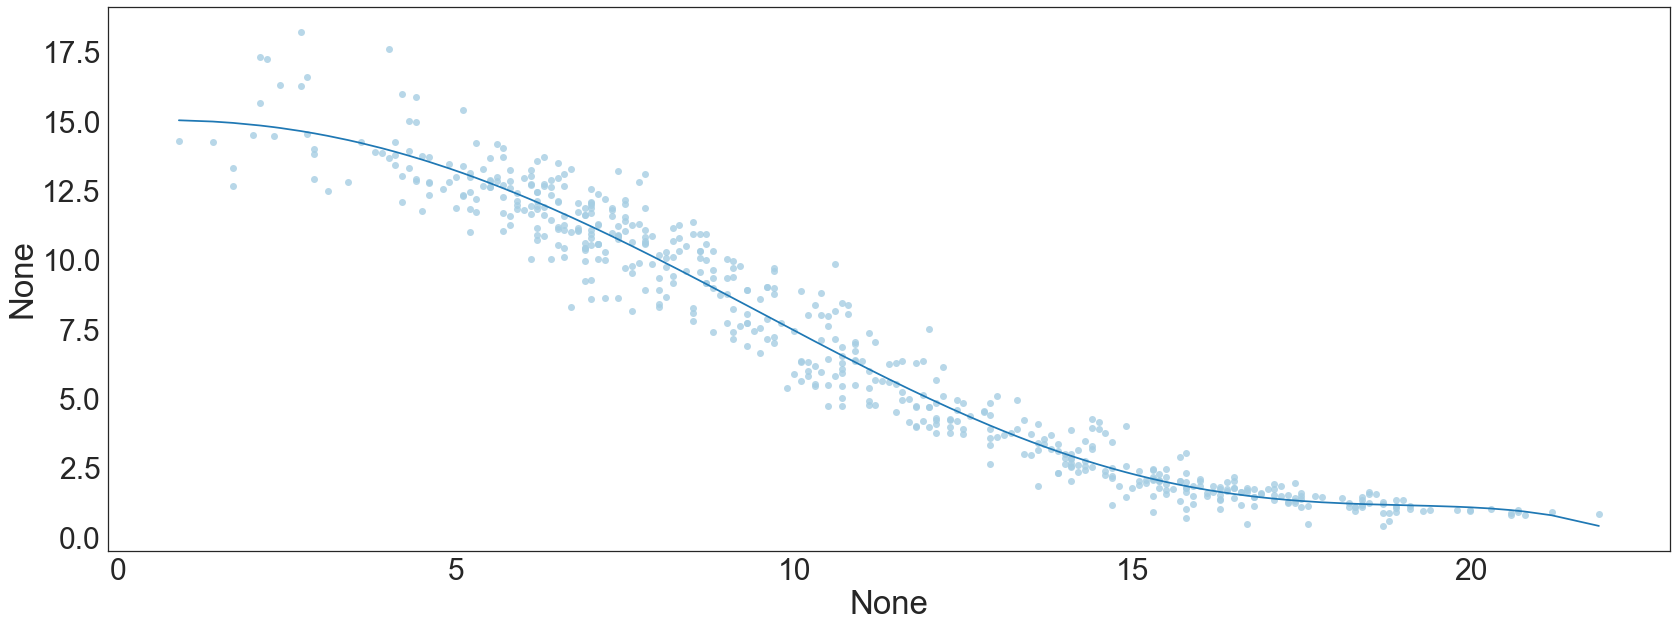

2
cluster: 2 silhouette score: 0.613824223677 calinski_harabaz: 1681.62613361
Number of values over average: 380 (66.1%)
3
cluster: 3 silhouette score: 0.484219330785 calinski_harabaz: 1408.13637815
Number of values over average: 313 (54.4%)
4
cluster: 4 silhouette score: 0.39704793105 calinski_harabaz: 1265.75185588
Number of values over average: 266 (46.3%)
5
cluster: 5 silhouette score: 0.357506810898 calinski_harabaz: 1115.77499935
Number of values over average: 237 (41.2%)
6
cluster: 6 silhouette score: 0.347343279189 calinski_harabaz: 988.433423913
Number of values over average: 226 (39.3%)
7
cluster: 7 silhouette score: 0.310066627314 calinski_harabaz: 888.986432898
Number of values over average: 221 (38.4%)
8
cluster: 8 silhouette score: 0.284055503628 calinski_harabaz: 802.499268051
Number of values over average: 215 (37.4%)
9
cluster: 9 silhouette score: 0.287081968541 calinski_harabaz: 728.024881566
Number of values over average: 216 (37.6%)


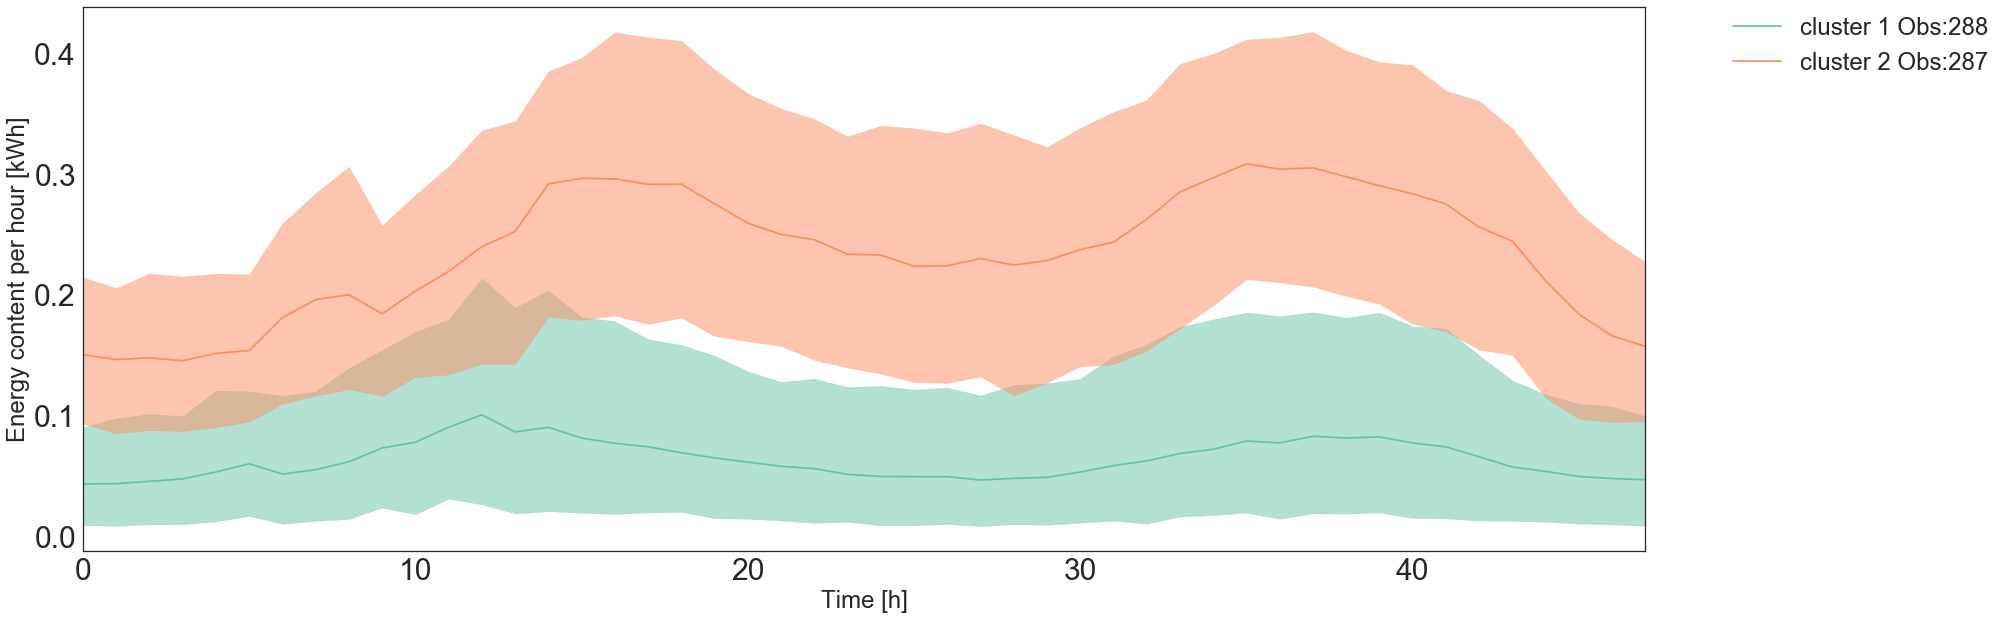

In [109]:
GSHP=GSHP.join(temperature)
GSHP["Temperature"].fillna(method="ffill", inplace=True)
getprofiles(GSHP)

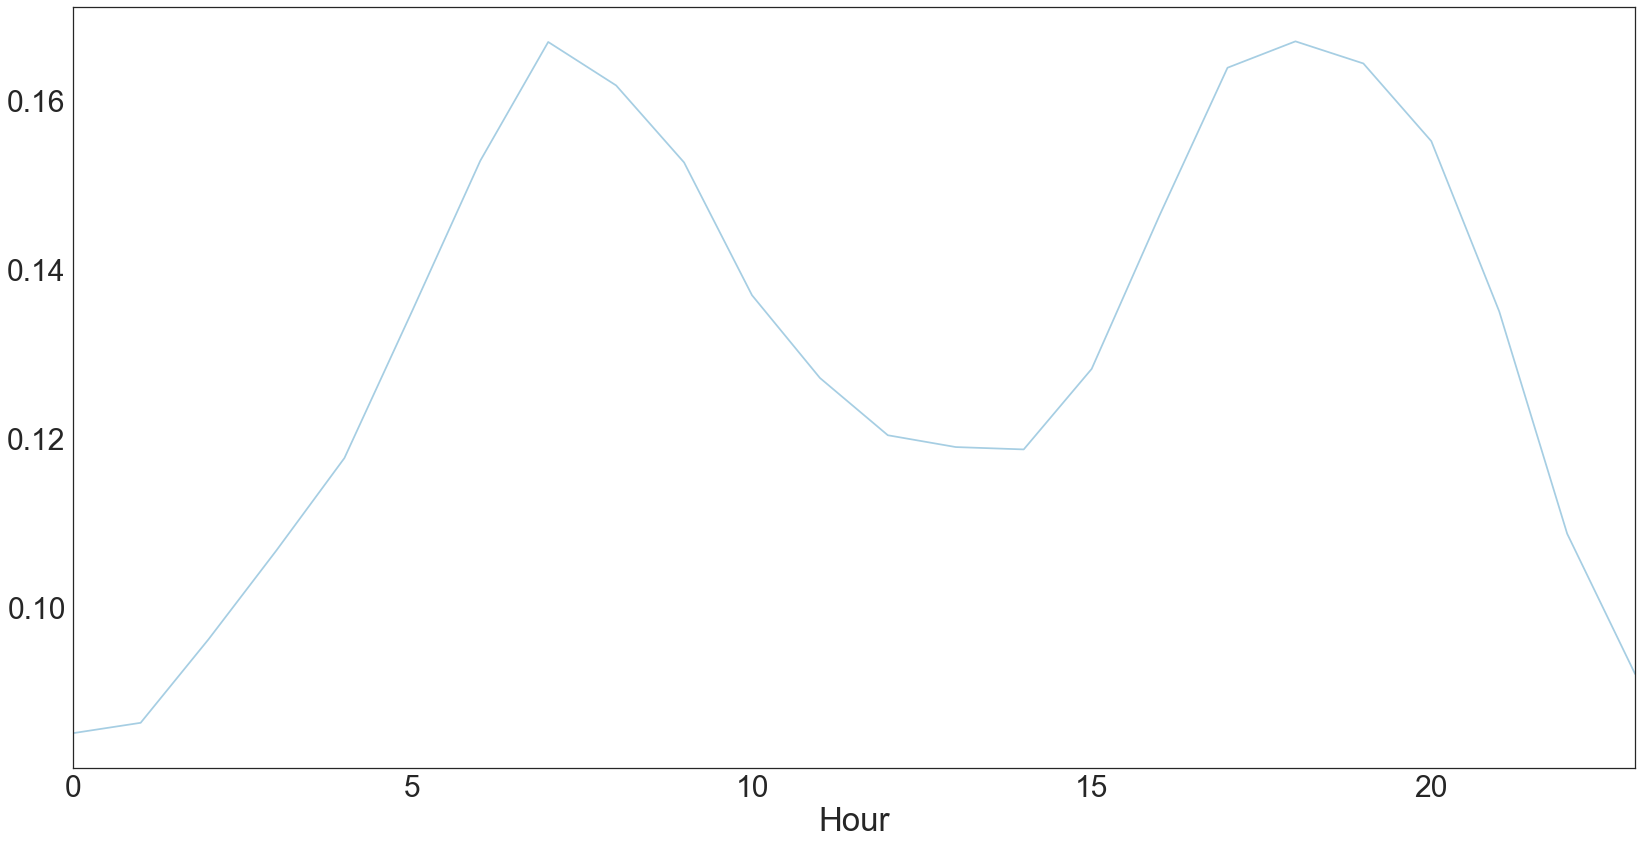

In [110]:
fig, ax = plt.subplots(figsize=(28, 14))
temp=GSHP.groupby(["DayOfYear", "Hour"]).mean().unstack()["Ehp"].T
temp.mean(axis=1).plot(ax=ax)
# ax.legend_.remove()

In [111]:
ASHP=ASHP.join(temperature)
ASHP["Temperature"].fillna(method="ffill", inplace=True)
ASHP.reset_index(drop=True,inplace=True)

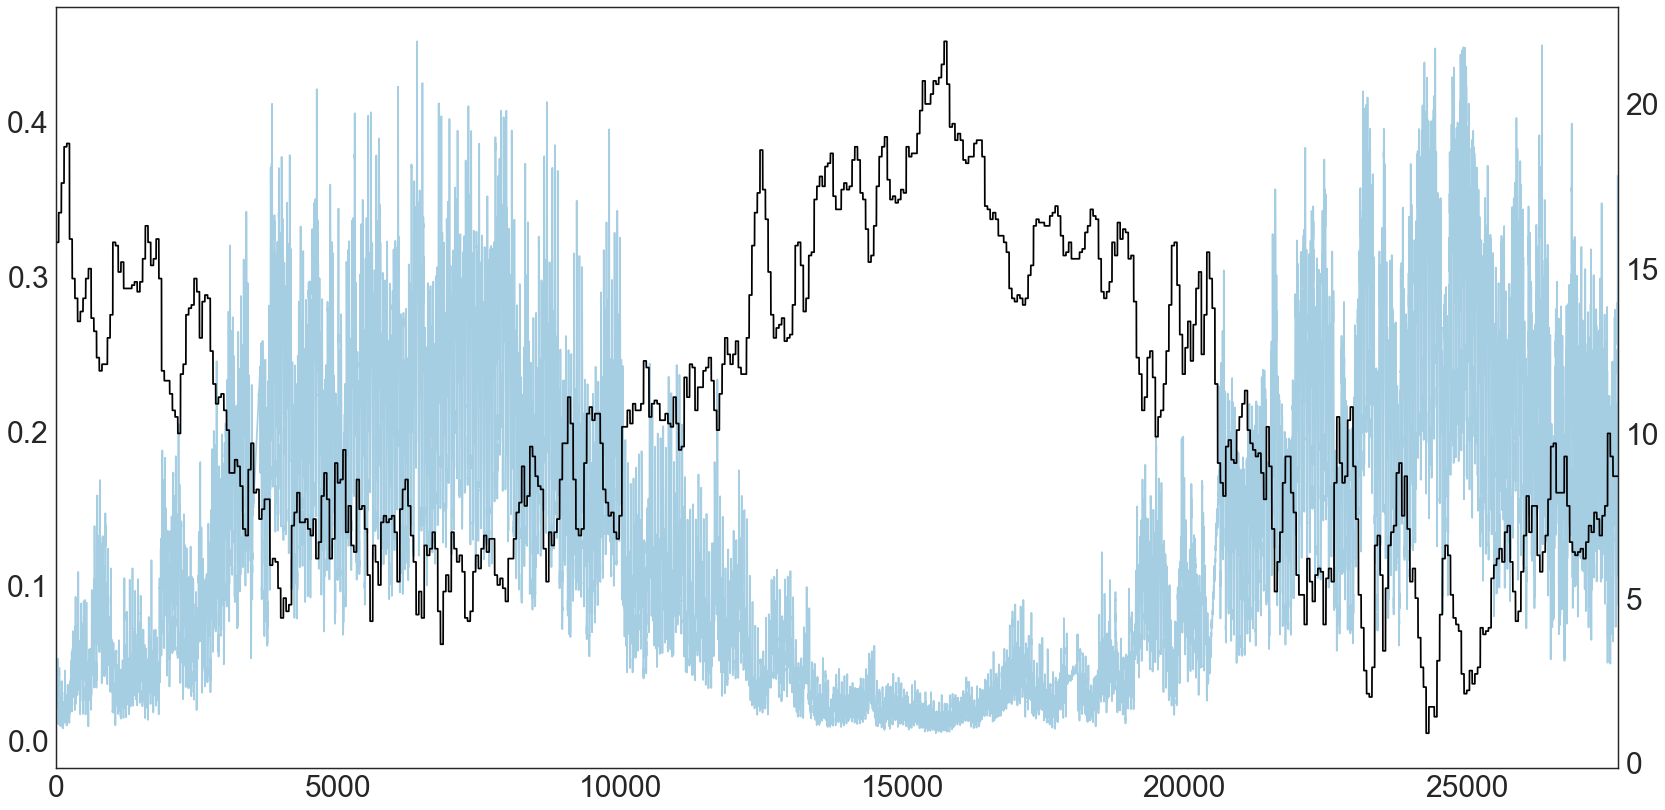

In [112]:
fig, ax = plt.subplots(figsize=(28, 14))
ax2=ax.twinx()
# find_fill_outliers(ASHP, "Ehp", True, True)
ASHP["Ehp"].plot(ax=ax)
ASHP["Temperature"].plot(ax=ax2, color='black')
# GSHP["Ehp"].plot(ax=ax)
# GSHP["Temperature"].plot(ax=ax2, color='black')
# GSHP_week = GSHP.groupby(["DayOfYear", "Hour"]).mean().unstack("Hour")["Ehp"]
# GSHP_week.T.plot(ax=ax)

In [113]:
# ASHP.loc[:, "Ehp" ]= ASHP.groupby("Date")["Ehp"].apply(lambda x: (x - x.min()) / (x.max()-x.min()))
week_df=ASHP.groupby(["Week", "HH"]).mean().unstack('HH').copy()
doy_df=ASHP.groupby(["Date", "HH"]).mean().unstack('HH').copy()
doy_df.dropna(how="any", axis=0, inplace=True)

In [114]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

def getMEF(x, y):
    # # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # # Train the model using the training sets
    regr.fit(x.reshape(-1,1), y.reshape(-1,1))
    y_predict = regr.predict(x.reshape(-1,1))

    # The coefficients
    MEF=regr.coef_[0][0]*1000
    # The root mean squared error: the best value is 0.0
    RMSE=math.sqrt(mean_squared_error(y.reshape(-1,1), y_predict))

    return MEF, RMSE

In [115]:
temp = pd.DataFrame()
temp["Ehp"]=doy_df["Ehp"].sum(axis=1)
temp["Temperature"]=doy_df["Temperature"].mean(axis=1)
temp.sort_values("Temperature", ascending=True, inplace=True)

In [116]:
X=np.array(temp["Temperature"]).reshape(-1, 1)
y=np.array(temp["Ehp"]).reshape(-1, 1)

In [117]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(6), Ridge())
model.fit(X, y)
y_2 = model.predict(X)
RMSE=np.sqrt(mean_squared_error(y, y_2))

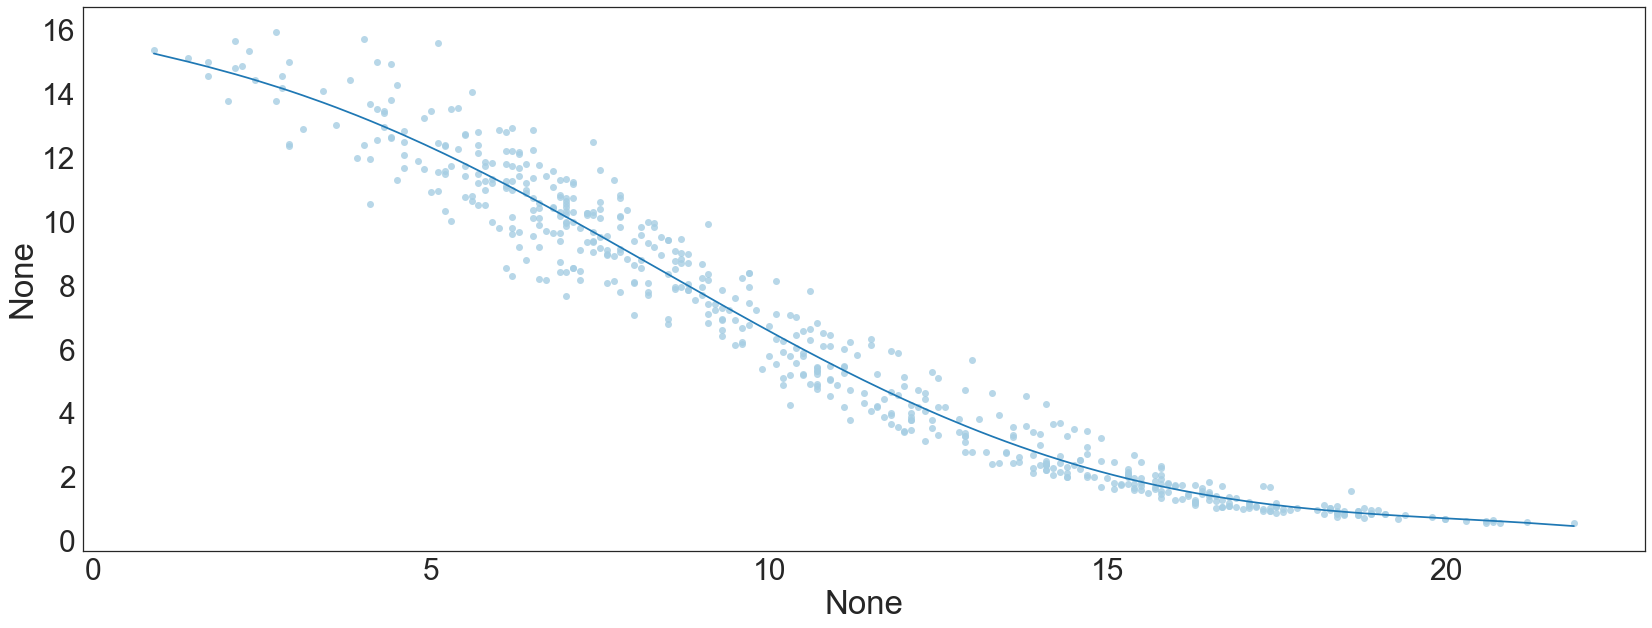

In [118]:
fig, ax = plt.subplots(figsize=(28, 10))
sns.regplot(x=doy_df["Temperature"].mean(axis=1), y=doy_df["Ehp"].sum(axis=1), fit_reg=False, ax=ax, label="half-hourly")
plt.plot(X, y_2)

In [119]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [120]:
doy_Ehp = doy_df["Ehp"].dropna(how="any", axis=0).reset_index(drop=True).copy()

In [121]:
frames=[]
for i in doy_Ehp.index:
    frames.append(acf(doy_Ehp.iloc[i, 0:48], nlags=48))
    
df_ACF = pd.DataFrame(frames)
df_ACF.values

array([[ 1.        ,  0.67735682,  0.5069037 , ...,  0.17588792,
         0.11650286,  0.05255111],
       [ 1.        ,  0.87092836,  0.81770011, ..., -0.0150634 ,
        -0.01417899,  0.00765735],
       [ 1.        ,  0.53682663,  0.48468123, ...,  0.02478176,
        -0.02716533,  0.0145525 ],
       ..., 
       [ 1.        ,  0.89579288,  0.75248935, ...,  0.12993335,
         0.0897265 ,  0.03550552],
       [ 1.        ,  0.84828456,  0.68045258, ...,  0.15930355,
         0.12148926,  0.05381708],
       [ 1.        ,  0.84462018,  0.73308113, ...,  0.06259065,
         0.04770598,  0.04469826]])

2
cluster: 2 silhouette score: 0.360594509642 calinski_harabaz: 441.883824372
Number of values over average: 343 (59.8%)
3
cluster: 3 silhouette score: 0.238393547975 calinski_harabaz: 320.333778301
Number of values over average: 292 (50.9%)
4
cluster: 4 silhouette score: 0.246747715238 calinski_harabaz: 273.881659967
Number of values over average: 298 (51.9%)
5
cluster: 5 silhouette score: 0.241317033157 calinski_harabaz: 257.825713154
Number of values over average: 285 (49.7%)
6
cluster: 6 silhouette score: 0.227139532145 calinski_harabaz: 238.310718762
Number of values over average: 276 (48.1%)
7
cluster: 7 silhouette score: 0.224855563085 calinski_harabaz: 221.103842754
Number of values over average: 276 (48.1%)
8
cluster: 8 silhouette score: 0.214709938919 calinski_harabaz: 208.784972355
Number of values over average: 290 (50.5%)
9
cluster: 9 silhouette score: 0.21667061192 calinski_harabaz: 199.55390221
Number of values over average: 285 (49.7%)


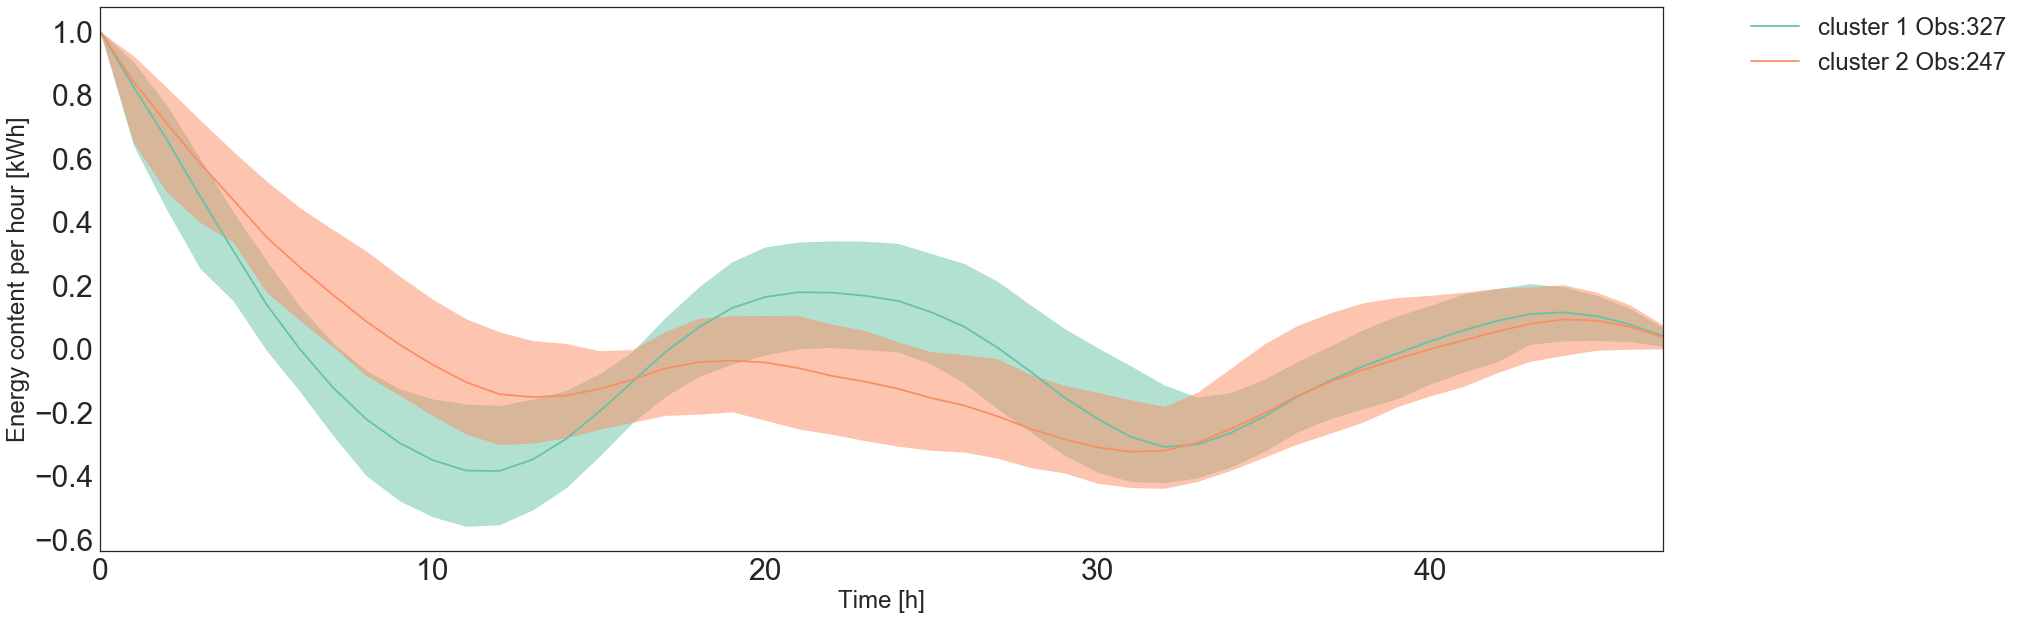

(array([ 1.        ,  0.65194192,  0.49547491,  0.40104117,  0.33825878,
         0.18082145,  0.09212522,  0.00882167, -0.08224067, -0.14363376,
        -0.20776749, -0.26577919, -0.29870072, -0.29407449, -0.27743527,
        -0.25063094, -0.22863926, -0.20685543, -0.20319871, -0.19585907,
        -0.22218687, -0.24955878, -0.26647766, -0.28652506, -0.30411275,
        -0.31677856, -0.32291259, -0.34207607, -0.3719765 , -0.38815076,
        -0.42091207, -0.43411043, -0.43668944, -0.41488554, -0.38012195,
        -0.33877297, -0.29719851, -0.26290402, -0.22703565, -0.17983645,
        -0.14529864, -0.11581479, -0.07289515, -0.03682391, -0.01818914,
        -0.00169179,  0.00128773,  0.00223408]),
 array([ 1.        ,  0.92342075,  0.82336855,  0.72134874,  0.62201068,
         0.5288212 ,  0.44553055,  0.37606701,  0.30889084,  0.23017281,
         0.15664602,  0.0955701 ,  0.0549885 ,  0.02695877,  0.01818045,
        -0.00426816, -0.00113392,  0.0557561 ,  0.0977507 ,  0.10546713,
  

In [122]:
nb_clusters, cluster_centers, cluster_labels = cluster(df_ACF.values, 10)
df_ACF["Labels Kmeans"] = cluster_labels
df_ACF.set_index("Labels Kmeans", append=True, inplace=True)
display_clusters(df_ACF, nb_clusters, cluster_centers," week")

2
cluster: 2 silhouette score: 0.625282822503 calinski_harabaz: 1741.57209784
Number of values over average: 366 (63.8%)
3
cluster: 3 silhouette score: 0.509327672245 calinski_harabaz: 1623.50559473
Number of values over average: 313 (54.5%)
4
cluster: 4 silhouette score: 0.464793012305 calinski_harabaz: 1650.72249781
Number of values over average: 299 (52.1%)
5
cluster: 5 silhouette score: 0.433174027719 calinski_harabaz: 1584.86699427
Number of values over average: 275 (47.9%)
6
cluster: 6 silhouette score: 0.404271010468 calinski_harabaz: 1450.87753599
Number of values over average: 263 (45.8%)
7
cluster: 7 silhouette score: 0.345025242561 calinski_harabaz: 1347.87673349
Number of values over average: 248 (43.2%)
8
cluster: 8 silhouette score: 0.343257119454 calinski_harabaz: 1268.11692737
Number of values over average: 249 (43.4%)
9
cluster: 9 silhouette score: 0.32244983468 calinski_harabaz: 1207.60091612
Number of values over average: 260 (45.3%)


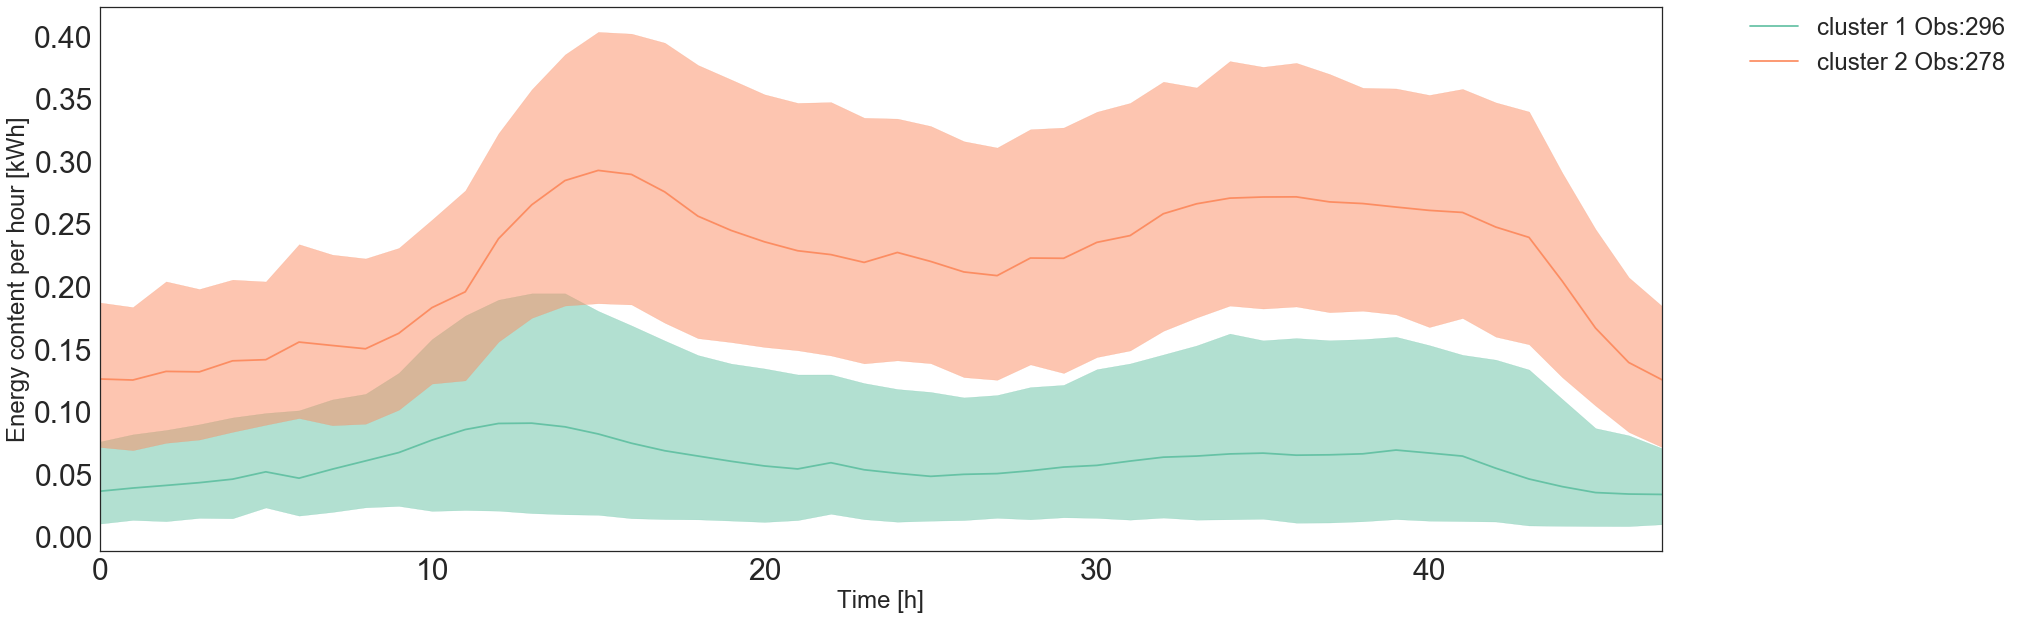

(array([ 0.0722116 ,  0.06969378,  0.07554953,  0.07816319,  0.08433046,
         0.08997263,  0.09533584,  0.08960102,  0.09078631,  0.10197572,
         0.12287449,  0.12542674,  0.15638131,  0.17539014,  0.18519474,
         0.1870278 ,  0.18605015,  0.17145974,  0.15913795,  0.15597939,
         0.15210982,  0.1494709 ,  0.14530734,  0.13900059,  0.1413985 ,
         0.13913526,  0.12802762,  0.12586467,  0.13817932,  0.13131436,
         0.14405616,  0.14932198,  0.16501581,  0.17564811,  0.18513266,
         0.18279151,  0.18443159,  0.17986901,  0.18104143,  0.17811401,
         0.16802303,  0.17520889,  0.16031746,  0.15425378,  0.12789673,
         0.10526996,  0.0841841 ,  0.07216959]),
 array([ 0.1876151 ,  0.18393376,  0.20441868,  0.19835696,  0.2058277 ,
         0.20436075,  0.23411975,  0.22580853,  0.22275461,  0.23115455,
         0.25377635,  0.27705514,  0.32274372,  0.35780164,  0.38567586,
         0.40372636,  0.40231272,  0.39506766,  0.37726063,  0.36563724,
  

In [123]:
doy_Ehp = doy_df["Ehp"].dropna(how="any", axis=0).reset_index(drop=True).copy()
    
nb_clusters, cluster_centers, cluster_labels = cluster(doy_Ehp.values, 10)
doy_Ehp["Labels Kmeans"] = cluster_labels
doy_Ehp.set_index("Labels Kmeans", append=True, inplace=True)
display_clusters(doy_Ehp, nb_clusters, cluster_centers, "week")

In [124]:
y2= [ 0.0722116 ,  0.06969378,  0.07554953,  0.07816319,  0.08433046,
         0.08997263,  0.09533584,  0.08960102,  0.09078631,  0.10197572,
         0.12287449,  0.12542674,  0.15638131,  0.17539014,  0.18519474,
         0.1870278 ,  0.18605015,  0.17145974,  0.15913795,  0.15597939,
         0.15210982,  0.1494709 ,  0.14530734,  0.13900059,  0.1413985 ,
         0.13913526,  0.12802762,  0.12586467,  0.13817932,  0.13131436,
         0.14405616,  0.14932198,  0.16501581,  0.17564811,  0.18513266,
         0.18279151,  0.18443159,  0.17986901,  0.18104143,  0.17811401,
         0.16802303,  0.17520889,  0.16031746,  0.15425378,  0.12789673,
         0.10526996,  0.0841841 ,  0.07216959]
y1=[ 0.1876151 ,  0.18393376,  0.20441868,  0.19835696,  0.2058277 ,
         0.20436075,  0.23411975,  0.22580853,  0.22275461,  0.23115455,
         0.25377635,  0.27705514,  0.32274372,  0.35780164,  0.38567586,
         0.40372636,  0.40231272,  0.39506766,  0.37726063,  0.36563724,
         0.35384892,  0.34700808,  0.34764812,  0.33512615,  0.33446166,
         0.32853585,  0.31640002,  0.31132181,  0.32597913,  0.32731397,
         0.3399294 ,  0.34698099,  0.36394968,  0.35930591,  0.38039791,
         0.37580306,  0.37897677,  0.37006707,  0.35907005,  0.35852699,
         0.35335272,  0.35815915,  0.34738954,  0.34007357,  0.29114878,
         0.24612168,  0.20763491,  0.18473254]

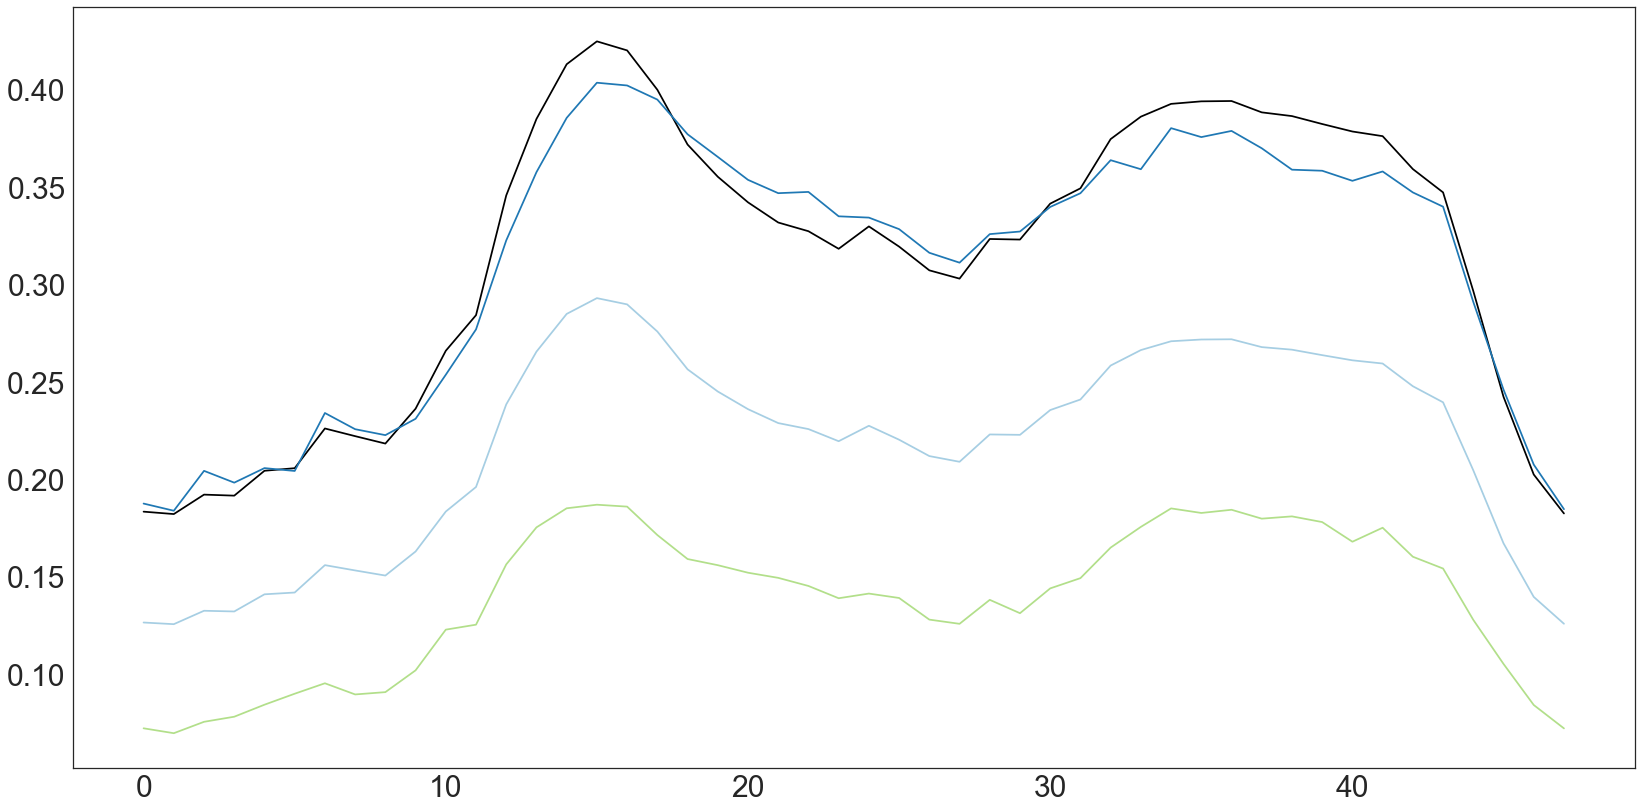

In [125]:
fig, ax = plt.subplots(figsize=(28, 14))
x=[x for x in range(0, 48,1)]
test= [val*(model.predict(1).ravel()[0]/model.predict(6.7).ravel()[0]) for val in cluster_centers[1]]
plt.plot(x, test, color='black')
plt.plot(x, cluster_centers[1])
plt.plot(x, y1)
plt.plot(x, y2)

In [126]:
temp_df=doy_Ehp.reset_index(drop=True).copy()
temp_df.columns = [str(x) for x in temp_df.columns]
temp_df["Total"]=temp_df.loc[:, "0":"47"].sum(axis=1)
temp_df["Temperature"]=doy_df["Temperature"].mean(axis=1).values
temp_df["Labels Kmeans"]=cluster_labels
print(temp_df.loc[temp_df["Labels Kmeans"]==1, "Temperature"].mean())
print(temp_df.loc[temp_df["Labels Kmeans"]==0, "Temperature"].mean())

6.6996402877697845
14.549324324324335


In [137]:
bins=[0, 5, 10, 15, 20, 25]
group_names=["0-5", "5-10", "10-15", "15-20", "20-25"]
temp_df["Temperature cat"]=pd.cut(temp_df["Temperature"], bins, labels=group_names)

In [207]:
temp_df["Date"]=doy_df.index

{'0-5': 3.577083333333334,
 '10-15': 12.381366459627332,
 '15-20': 16.934645669291342,
 '20-25': 20.850000000000005,
 '5-10': 7.332608695652172}

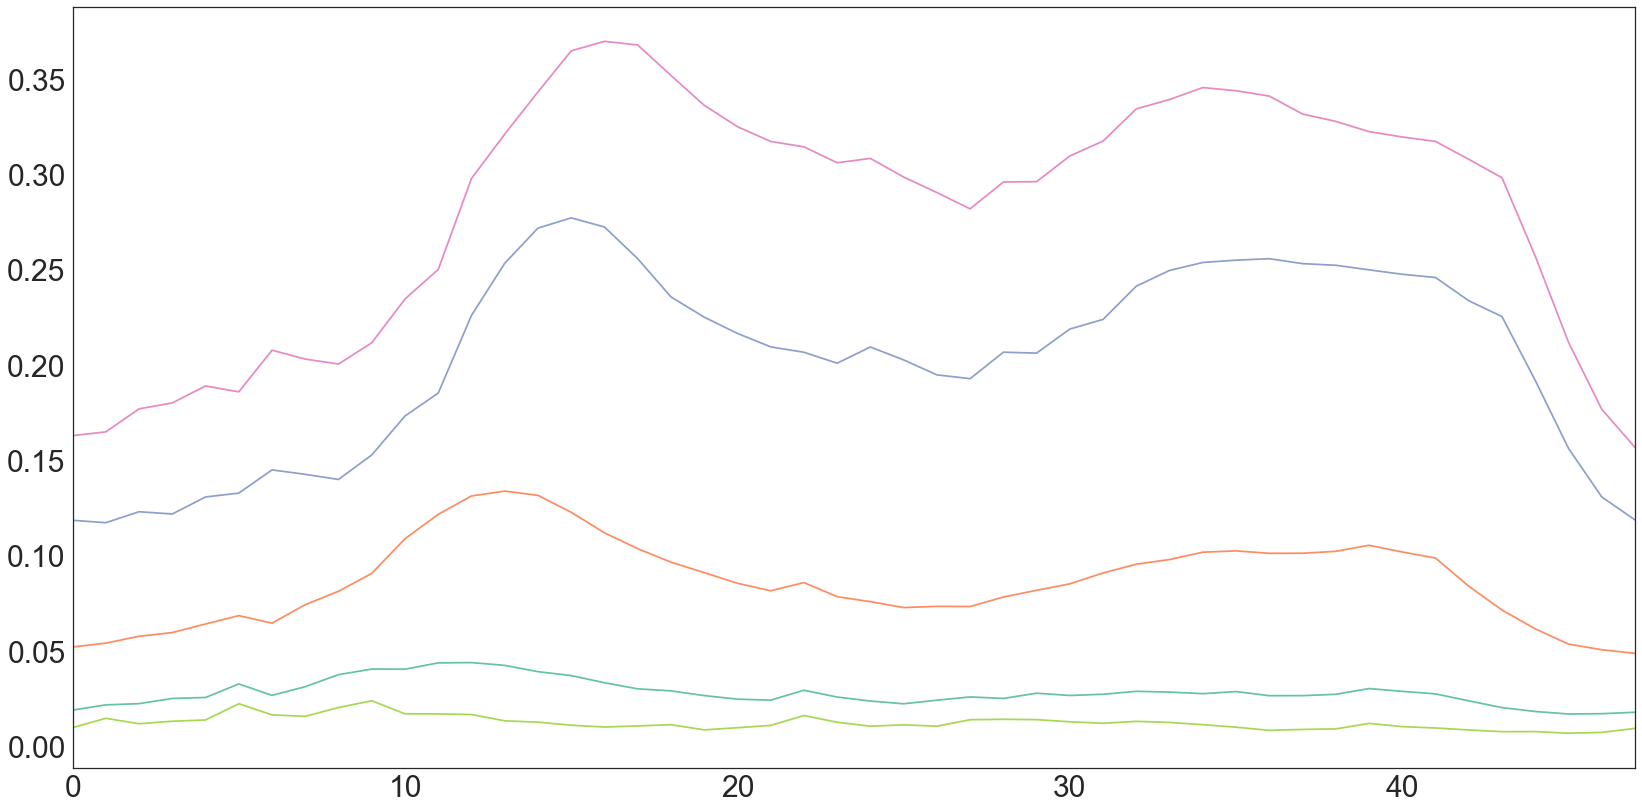

In [174]:
col=['blue', 'green']
col=sns.color_palette("Set2", 10)
fig, ax = plt.subplots(figsize=(28, 14))
count=0
mean_HP_profiles={}
mean_HP_temperature={}
for cluster in temp_df["Temperature cat"].unique():
    mean_profile=temp_df.loc[temp_df["Temperature cat"]==cluster, "0": "47"].mean(axis=0).values
    mean_profile_temp=temp_df.loc[temp_df["Temperature cat"]==cluster, "Temperature"].mean()
    temp_df.loc[temp_df["Temperature cat"]==cluster, "0": "47"].mean(axis=0).plot(ax=ax, c=col[count])
    mean_HP_profiles[cluster]=mean_profile
    mean_HP_temperature[cluster]=mean_profile_temp
    count=count+1
mean_HP_temperature

In [128]:
doy_Ehp["Temperature"] = doy_df["Temperature"].mean(axis=1).values
doy_Ehp.reset_index(inplace=True)

In [129]:
bins=[0, 5, 10, 15, 20, 25]
group_names=["0-5", "5-10", "10-15", "15-20", "20-25"]
doy_Ehp["Temperature cat"]=pd.cut(doy_Ehp["Temperature"], bins, labels=group_names)

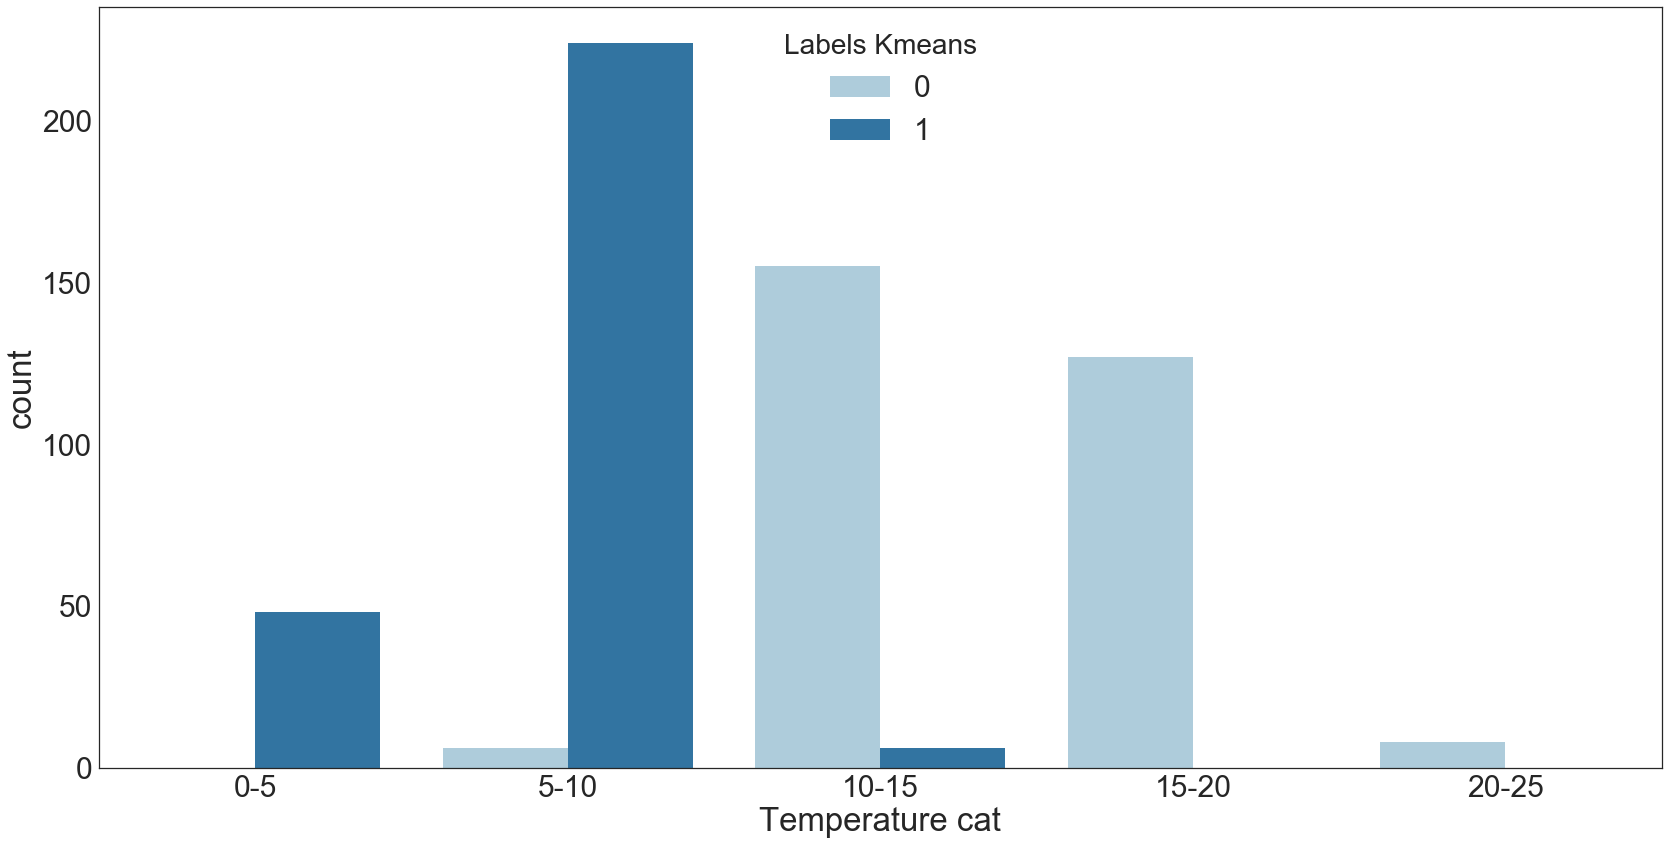

In [130]:
fig, ax = plt.subplots(figsize=(28, 14))
ax = sns.countplot(x="Temperature cat", hue="Labels Kmeans", data=doy_Ehp, ax=ax)

In [195]:
ASHP["Year"]=[int(x.split('-')[0]) for x in ASHP["Date"]]

In [153]:
bins=[0, 5, 10, 15, 20, 25]
group_names=["0-5", "5-10", "10-15", "15-20", "20-25"]
temperature["Temperature cat"]=pd.cut(temperature["Temperature"], bins, labels=group_names)


In [209]:
temperature["Year"]=temperature.index.year
mean_temp_cluster_1 = temp_df.loc[temp_df["Labels Kmeans"]==1, "Temperature"].mean()
mean_temp_cluster_0 =temp_df.loc[temp_df["Labels Kmeans"]==0, "Temperature"].mean()

frames=[]
for row in temperature.loc[temperature["Year"]==2014, :].iterrows():
    profile=mean_HP_profiles[row[1]["Temperature cat"]]
    frames.append(profile*model.predict(row[1]["Temperature"]).ravel()[0]/model.predict(mean_HP_temperature[row[1]["Temperature cat"]]).ravel()[0])
    
#     model.predict(value).ravel()[0]/model.predict(mean_temp_cluster_0).ravel()[0])

HP_2014=pd.DataFrame(frames, columns=x).stack().reset_index()
HP_2014.drop(["level_0", "level_1"], axis=1, inplace=True)
HP_2014.columns=["ASHP"]
RMSE=math.sqrt(mean_squared_error(ASHP.loc[ASHP["Year"]==2014, "Ehp"].values.reshape(-1,1), HP_2014.values))
r2_score(ASHP.loc[ASHP["Year"]==2014, "Ehp"].values.reshape(-1,1), HP_2014.values) 

0.93752205960081803

In [208]:
from sklearn.metrics import r2_score

temperature["Year"]=temperature.index.year
mean_temp_cluster_1 = temp_df.loc[temp_df["Labels Kmeans"]==1, "Temperature"].mean()
mean_temp_cluster_0 =temp_df.loc[temp_df["Labels Kmeans"]==0, "Temperature"].mean()

frames=[]
for value in temperature.loc[temperature["Year"]==2014, "Temperature"]:
    if value<=10:
        frames.append(cluster_centers[1]*model.predict(value).ravel()[0]/model.predict(mean_temp_cluster_1).ravel()[0])
    else:
        frames.append(cluster_centers[0]*model.predict(value).ravel()[0]/model.predict(mean_temp_cluster_0).ravel()[0])
        
HP_2014=pd.DataFrame(frames, columns=x).stack().reset_index()
HP_2014.drop(["level_0", "level_1"], axis=1, inplace=True)
HP_2014.columns=["ASHP"]
RMSE=math.sqrt(mean_squared_error(ASHP.loc[ASHP["Year"]==2014, "Ehp"].values.reshape(-1,1), HP_2014.values))
r2_score(ASHP.loc[ASHP["Year"]==2014, "Ehp"].values.reshape(-1,1), HP_2014.values)     


0.91688923345565576

In [176]:
x = [str(x) for x in range(0, 48,1)]
HP_2016=pd.DataFrame(frames, columns=x).stack().reset_index()
HP_2016.drop(["level_0", "level_1"], axis=1, inplace=True)
HP_2016.columns=["ASHP"]
start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
HP_2016["Date"] = pd.date_range(start=start, end=end, freq='30min')
HP_2016.set_index("Date", inplace=True)
HP_2016=HP_2016.join(temperature)
HP_2016.fillna(method='ffill', inplace=True)

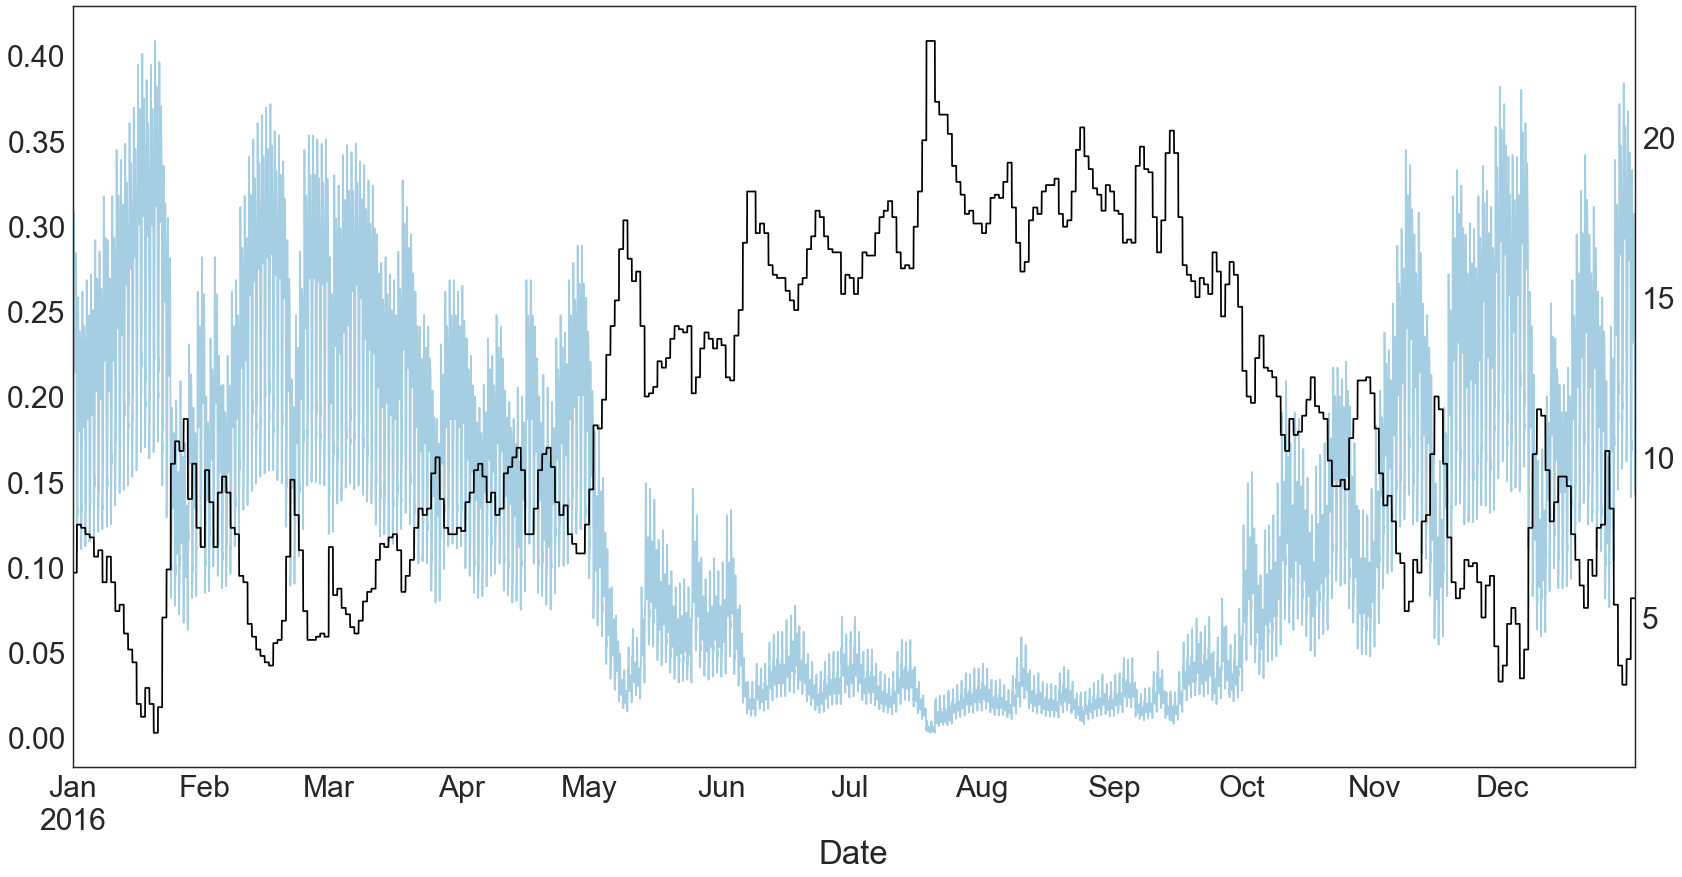

In [177]:
fig, ax = plt.subplots(figsize=(28, 14))
ax2=ax.twinx()
HP_2016["ASHP"].plot(ax=ax)
HP_2016["Temperature"].plot(ax=ax2, color='black')